In [143]:
import numpy as np, pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os

import warnings
warnings.simplefilter (action='ignore', category=(FutureWarning, UserWarning))



In [144]:
#convert T1/T2 nvj rate analysis data into one DataFrame.
#current expected files are <sample>_<expt>rates.txt and <sample>_<expt>tau.txt # adjust as needed
#python note: sample is a protected word, can't use blah_df.sample because it means something else

data_dir = '/home/tuttle/data/nmrdata/gal4_ABD1/gal4AD_t1t2/fits'

#samples = ['WT', 'WTMannose', 'L34A','L34AMannose','L34K','L34KMannose','27C-34C','27C-34CMannose']
samples = ['gal4AD','gal4AD_ABD1']
residues = range(830,882) #I have numbered side chain residues as e.g. 840.ne is 8400, otherwise get duplicate residues
exp=['T1','T2']

newrows=[]

for sample in samples:
    for expt in exp:
        f=os.path.join(data_dir,sample+"_"+expt+"rates.txt")
        df=os.path.join(data_dir,sample+"_"+expt+"tau.txt")
        
        delaydict=dict()

        delayobject = open(df)
        for line in delayobject:
            values = line.rstrip().replace('\t',' ').split(' ')
            if len(values)==2:   #ignore blank lines at end of file
                delaydict['T'+values[0]]=float(values[1])
            #print(values)
        #print(delaydict)

        data = pd.read_csv(f,delimiter="\t").dropna()
        for record in data.to_records():
                for i in range(1,len (delaydict)+1): #since there are 8 delays used for each experiment
                        newrow = {'Residue':int(record['Residue']), #removed conversion to string to autosort residue order
                                  'sample':sample,
                                  'expt':expt,
                                  'Intensity':record['T'+str(i)],
                                  'delay':delaydict['T'+str(i)]}
                        newrows.append(newrow)

dynamics=pd.DataFrame.from_records(newrows)

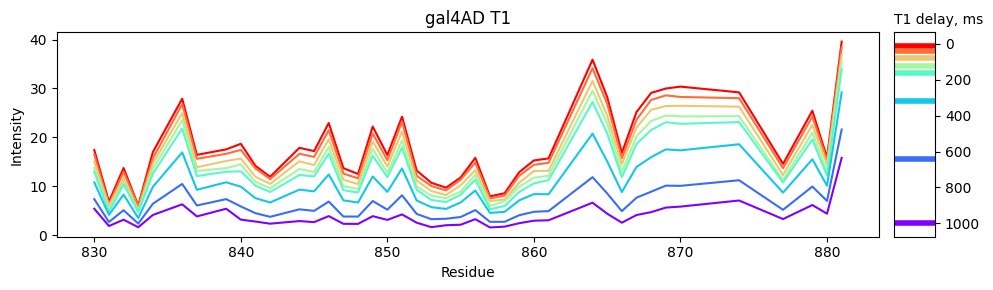

In [167]:
sample = 'gal4AD'
expt = 'T1'
fig, ax = plt.subplots(1,2,figsize=(10, 3), gridspec_kw={'width_ratios':[20,1]} )
plot_data = dynamics.copy()[(dynamics['sample'] == sample) & (dynamics['expt']==expt)]
plot_data = plot_data[plot_data['Residue'].isin(residues)]
delays = sorted(plot_data['delay'].unique())
color = iter(cm.rainbow(np.linspace(1,0,len(delays))))
padding = .075*delays[-1] #this value is for the colorbar to make sure bands don't fall on top and bottom edges

for delay in delays:
    c = next(color)
    plot_data[plot_data['delay']==delay].plot(x='Residue',y='Intensity',ax=ax[0],c=c)
    ax[0].set_ylabel("Intensity")
    ax[1].plot([0,1],[delay,delay],color=c,linewidth=4)
    ax[1].yaxis.tick_right()
    ax[1].axes.get_xaxis().set_visible(False)
ax[0].get_legend().remove()
ax[0].set_title(sample+" "+expt)
ax[1].set_title(expt+" delay, ms",fontsize=10, loc="left")
ax[1].set_ylim(delays[-1]+padding,delays[0]-padding)
#fig.suptitle(sample+" "+expt)
fig.tight_layout()
plt.show()

In [146]:
## curve fitting...

def expdecay(time, Iref, rate):
    return Iref * np.exp(-1*rate*time)


fits = []

for sample in samples:
    noise = [5.0] #should be picked correctly, this is just a dummy value
    for expt in exp:
        expt_data = dynamics.copy()[(dynamics.expt == expt) & (dynamics['sample'] == sample)]
        #print(expt_data)
        peaks = expt_data.Residue.unique()
        for peak in peaks:
            focal_data = expt_data.copy()[expt_data.Residue == peak]
            focal_data = focal_data.copy()[focal_data.Intensity > noise[0]] #experimental filtering by noise
            
            x = list(focal_data.delay/1000)
            y = list(focal_data.Intensity)
            y_err = noise * len(y)
            
            x0 = [focal_data.Intensity.max(), 10]
            
            if len(focal_data) > 2:
                fit,covar = curve_fit(expdecay, x, y, sigma=y_err, p0=x0,maxfev=20000)
                fits.append( [peak, sample, expt, fit[1], covar[1][1]] )

fit_dyn = pd.DataFrame(fits, columns=['Residue', 'sample', 'expt', 'rate', 'stderr'])
fit_dyn.head(3)



,Residue,sample,expt,rate,stderr
0,830,gal4AD,T1,1.289531,0.010741
1,831,gal4AD,T1,2.349824,0.149261
2,832,gal4AD,T1,1.583685,0.007473


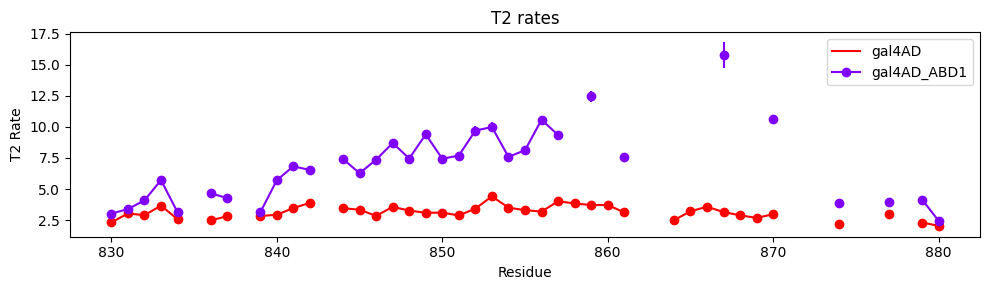

In [149]:
def fill_missing_range(df, field, range_from, range_to, range_step=1, fill_with=0):
    '''
    https://stackoverflow.com/a/43001606/21943039
    use this to fill in missing data to plot full residue range with gaps
    '''
    return df\
      .merge(how='right', on=field,
            right = pd.DataFrame({field:np.arange(range_from, range_to, range_step)}))\
      .sort_values(by=field).reset_index().fillna(fill_with).drop(['index'], axis=1)

compare_samples = samples #['gal4AD_ABD1']
expt = 'T2'
color = iter(cm.rainbow(np.linspace(1,0,len(samples))))
fig2, ax2 = plt.subplots(1,1,figsize=(10, 3), )#gridspec_kw={'width_ratios':[20,1]} )
for sample in compare_samples:
      c = next(color)
      plot_data = fit_dyn.copy()[(fit_dyn['sample'] == sample) & (fit_dyn['expt']==expt)]
      plot_data = plot_data[plot_data['Residue'].isin(residues)]
      plot_data = fill_missing_range(plot_data,'Residue',residues[0],residues[-1],1,np.nan)
      #plot_data.plot.bar(x='Residue',y='rate',yerr='stderr',ax=ax2,width=1.0,ec='black',color=c)
      plot_data.plot(x='Residue',y='rate',yerr='stderr',ax=ax2,c=c,label=sample,marker='o')
# 
# 


ax2.set_ylabel(expt+" Rate")
#ax2.get_legend().remove()
ax2.set_title(expt+" rates")
#fig2.suptitle(sample+" "+expt)
fig2.tight_layout()
plt.show()